## 主要预测模型
https://zhuanlan.zhihu.com/p/67832773  
http://itindex.net/detail/58931-python-%E6%97%B6%E9%97%B4%E5%BA%8F%E5%88%97-%E9%A2%84%E6%B5%8B  
https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts   
https://blog.csdn.net/FrankieHello/article/details/80883147

2020-04-11 00:00:28    1.0
2020-04-11 00:01:28    2.0
2020-04-11 00:02:28    2.0
2020-04-11 00:03:02    1.0
2020-04-11 00:04:02    2.0
dtype: float64
         timestamp  value
20   1586534428000    1.0
354  1586534488000    2.0
353  1586534548000    2.0
352  1586534582000    1.0
351  1586534642000    2.0


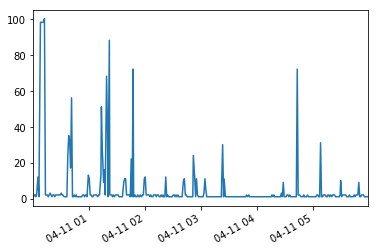

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules,fpgrowth
import networkx as nx
import csv
#from rootcause.association_analysis import alarm_association
from preutils import  timeseries_processor
import warnings
warnings.filterwarnings('ignore')  #忽略警告

 
if __name__=='__main__':
    
    pd.set_option('display.width', 1000)
    homePath = os.path.dirname(os.path.abspath('__file__'))
    # Windows下的存储路径与Linux并不相同
#data//20200411/platform/db_oracle_11g.csv

    if os.name == "nt":
        dataPath = "%s\\data\20200411\platform\dcos_docker.csv" % homePath
    else:
        dataPath = "%s/data/20200411/platform/dcos_docker.csv" % homePath
     
    itemid = 999999996381403
    cmdbid = 'docker_003'
    indexname = 'container_cpu_used'
    bomcid = 'ZJ-004-059'
    
    docker=pd.read_csv(dataPath)
    #docker.head()
    dockergrouped = docker.groupby(['itemid','name','bomc_id'])
    #for item in dockergrouped.itemid:
    alarmtime = [1586534700000]
    dtdata  = docker[  (docker['itemid']==itemid) & (docker['cmdb_id']==cmdbid) & (docker['name']==indexname)][['timestamp','value']]
    #timeseries = dtdata['value'].values
    #dockertime1 = docker.loc[(docker['timestamp'] <= alarmtime)&(docker['timestamp']>alarmtime- 300000)]
    #timeseries_set =  dockertime1['value'].values
    #print(dts.shape)
    dtdata.sort_values("timestamp",inplace=True)        
    dts = timeseries_processor.get_tsdata(dataPath,itemid,bomcid,indexname )
    print(dts.head())
    print(dtdata.head())
    dts.plot()

In [4]:
print(dts.shape)
train = dts[:346]
#train=train.set_index('timestamp')
test = dts[346:]
#test=test.set_index('timestamp')
print(train.shape,test.shape)   #预测后10个
train.head()


(356,)
(346,) (10,)


2020-04-11 00:00:28    1.0
2020-04-11 00:01:28    2.0
2020-04-11 00:02:28    2.0
2020-04-11 00:03:02    1.0
2020-04-11 00:04:02    2.0
dtype: float64

In [5]:
test

2020-04-11 05:49:27    9.0
2020-04-11 05:50:26    1.0
2020-04-11 05:51:25    1.0
2020-04-11 05:52:27    2.0
2020-04-11 05:53:28    2.0
2020-04-11 05:54:28    2.0
2020-04-11 05:55:28    1.0
2020-04-11 05:57:28    1.0
2020-04-11 05:58:28    1.0
2020-04-11 05:59:28    1.0
dtype: float64

### 朴素法
就是最简单的用前一天的数据预测后一天的

2.0


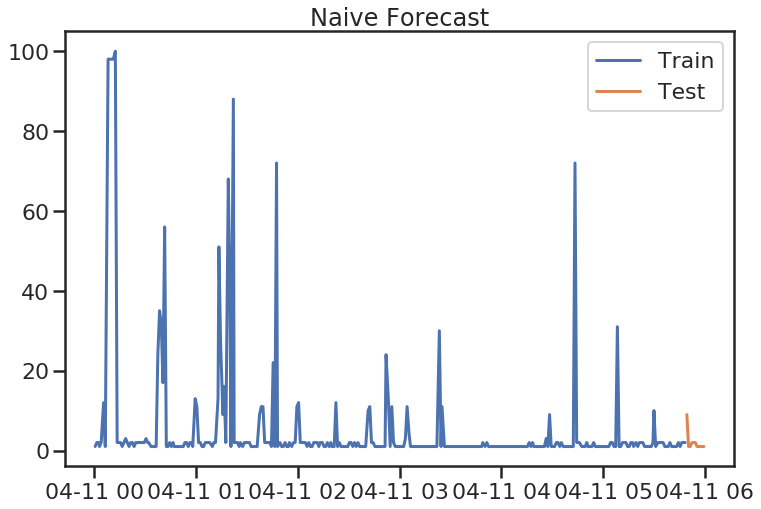

In [84]:
dd = np.asarray(train)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd) - 1]
print(y_hat['naive'])
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
#plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [ ]:
#朴素法并不适合变化很大的数据集，最适合稳定性很高的数据集。 用均方根误差检查模型在测试数据集上的准确率：
from sklearn.metrics import mean_squared_error
from math import sqrt
print(test.shape)
print(y_hat['naive'])
rms = sqrt(mean_squared_error(test, y_hat['naive']))
print(rms)

### 简单平均法
预期值等同于之前所有观测点的平均值的预测方法就叫简单平均法

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train.mean()
plt.figure(figsize=(12,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

### 移动平均法
之前数值的固定有限数p的平均值预测某个时序中的下一个值,p可以叫时间窗

In [ ]:
train = train.reset_index()
test = test.reset_index()
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train.rolling(50).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()


###  AR自回归模型

一般的回归我们预测的是其它数据看泛化能力，而自回归就是自己预测自己，通过自身前面部分的数据与后面部分的数据之间的相关关系（自相关）来建立回归方程，从而可以进行预测或者分析后面发生的数据。  
自回归方程满足如下形式，那么就说明它服从p阶的自回归过程，表示为AR(p)：  

$ x_t = \theta_1 x_{t-1}+\theta_2 x_{t-2} + ... +\theta_p x_{t-p} + u_t $  
其中，ut表示白噪声，是时间序列中的数值的随机波动，但是这些波动会相互抵消，最终是0。theta表示自回归系数。

所以当只有一个时间记录点时，称为一阶自回归过程，即AR(1),就是类似朴素法。    
$ x_t = \theta_1 x_{t-1} + u_t $  



###  Moving Average Model移动平均模型MA

通过将一段时间序列中白噪声序列进行加权和，可以得到移动平均方程。如为q阶移动平均过程，表示为MA(q)。theta表示移动回归系数。ut表示不同时间点的白噪声。就相当于一个滑动窗口q在移动，计算包含窗口里的平均值来预测。  
$ x_t = u_t + \theta_1 t_{t-1}+\theta_2 u_{t-2} ...+ \theta_q u_{t-q} $  
 


### ARMA(Auto Regressive and Moving Average Model)自回归移动平均模型
就是AR和MA的组合，自回归移动平均模型是与自回归和移动平均模型两部分组成。所以可以表示为ARMA(p, q)。p是自回归阶数，q是移动平均阶数。

$ x_t = u_t + \theta_1 t_{t-1}+\theta_2 u_{t-2} ...+ \theta_q u_{t-q} +  \beta_1 x_{t-1}+\beta_2 x_{t-2} + ... +\beta_p x_{t-p} $  


### ARIMA(Auto Regressive Integrate Moving Average Model)差分自回归移动平均模型

这个是最为常用的模型，简单说就是AR+integrate+MA。  
同前面的三种模型，ARIMA模型也是基于平稳的时间序列的或者差分化后是稳定的，另外前面的几种模型都可以看作ARIMA的某种特殊形式。表示为ARIMA(p, d, q)。p为自回归阶数，q为移动平均阶数，d为时间成为平稳时所做的差分次数，也就是Integrate单词的在这里的意思。

适用条件：  
在应用ARIMA模型时，要保证以下几点：
- 时间序列数据是相对稳定的，总体基本不存在一定的上升或者下降趋势，如果不稳定可以通过差分的方式来使其变稳定。
- 非线性关系处理不好，只能处理线性关系

判断时序数据稳定

基本判断方法：稳定的数据，总体上是没有上升和下降的趋势的，是没有周期性的，方差趋向于一个稳定的值。  
具体可以看均值、方差为常数，协方差仅仅与时间间隔相关。

![image.png](images/arima.jpg)

- 获取被观测系统时间序列数据；
- 对数据绘图，观测是否为平稳时间序列；对于非平稳时间序列要先进行d阶差分运算，化为平稳时间序列；
例如：
![image.png](images/integrate.jpg)
- 经过第二步处理，已经得到平稳时间序列。要对平稳时间序列分别求得其自相关系数ACF 和偏自相关系数PACF，通过对自相关图和偏自相关图的分析，得到最佳的阶层 p 和阶数 q
- 由以上得到的d、q、p，得到ARIMA模型。然后开始对得到的模型进行模型检验。 
 

具体判别过程如下面的表格所示。  
![image.png](images/arima.png)

p由显著不为0的偏自相关系数的数目决定，此时序列的偏自相关函数表现为

拖尾性，即当k>p时，偏自相关系数的值都在置信区间以内；q由显著不为0的自相关系数的数目决定，此时序列的

自相关函数表现为截尾性，即当k>p时，自相关系数的值都在置信区间内。这里的拖尾是指以指数率单调或振荡衰

减，截尾是指从某个开始非常小（不显著非零）。在平稳时间序列中，应用自相关函数和偏自相关函数在初步判断

ARMA模型的阶数p和q的基础上，然后通过最小信息准则AIC进行定阶。ARMA模型中p和q的的最佳估计可以通过

AIC准则给出，AIC比较适合在被观察样本数据较少的情况下使用。


#### 时间序列平稳性检测
很多时候时间序列分析都是单一指标而且没什么异常波动，但是很多实际情况是很难适用的，比如股票数据用ARIMA无法预测的原因就是股票数据是非稳定的。比如用电量预测，就可能结合ARIMA和svm，将其他相关特征也加入波动分析，进行综合考察。
还比如融资并购、人工造势、恶意商业活动、广告活动、促销活动、人为因素、系统问题等等，都对单一序列的波动造成影响，不能简单用Arima预测。

时间序列平稳性检测的方法有 ：  ADF( Augmented Dicky Fuller Test) ，KPSS ，PP (Phillips-Perron test)  

常用的是基于统计假设检验的ADF检测，类似F检验，检测方差一致性，这里既是检测波动程度，波动太大就不是平稳序列。  
1）ADF值判断平稳性需要根据1%、%5、%10不同程度拒绝原假设的统计值：1%：严格拒绝假设；5%：拒绝原假设；
10%类推。ADF值越小那么越拒绝原假设，越说明序列不存在单位根，那么时间序列越平稳。

2）p_value值要小于一个显著值，时间序列就是平稳的。一般以0.01为显著值。

(-6.5216409553714225, 1.0386361010498914e-08, 2, 353, {'1%': -3.4490114443793214, '5%': -2.8697627072503757, '10%': -2.5711506161673716}, 2496.2839994884675)


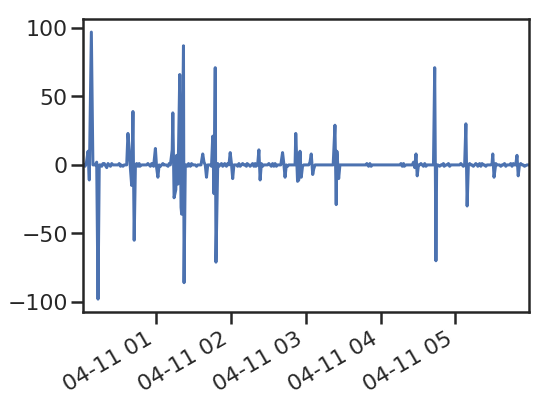

                                value
Test Statistic Value        -12.05796
p-value                       0.00000
Lags Used                           6
Number of Observations Used       348
Critical Value(1%)           -3.44928
Critical Value(5%)           -2.86988
Critical Value(10%)          -2.57121


In [111]:
#d就是差分的阶数，首先通过ADF检验，看原时间序列的平稳性，如果原时间序列是平稳的，那么d=0；

#如果原数据不平稳，那么做差分，通过ADF检验直到时间序列平稳。一般差分次数不超过2次。

#先看序列是否平稳，一般是非平稳的
import pandas as pd
import numpy as np
# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x)  # pandas
np.set_printoptions(precision=5, suppress=True)  # numpy
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# seaborn plotting style
sns.set(style='ticks', context='poster') 
#ADF 检测
print(smt.stattools.adfuller(dts))
#这里数据是平稳
#差分处理
#print(train.shape)
#diff_series = train.diff(1)#一阶
#diff_series2 = diff_series.diff(1)#二阶
#diff_series.plot()
#diff_series2.plot()
time_series = dts.diff(1)
#ime_sereis = dts
time_series = time_series.dropna(how=any)
time_series.plot(figsize=(8,6))
plt.show()
t=sm.tsa.stattools.adfuller(time_series)
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
print(output)

关键值1%、%5、%10不同程度拒绝原假设的统计值和ADF Test Statistic Value  的比较，ADF Test Statistic Value 同时小于1%、5%、10%即说明非常好地拒绝该假设，本数据中，adf结果为-12， 小于三个level的统计值。  
P-value是否非常接近0.本数据中，P-value 为 2e-15,接近0.  
ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。  
对于ADF结果在1% 以上 5%以下的结果，也不能说不平稳，关键看检验要求是什么样子的。


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff25303d9d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff252b2d390>)

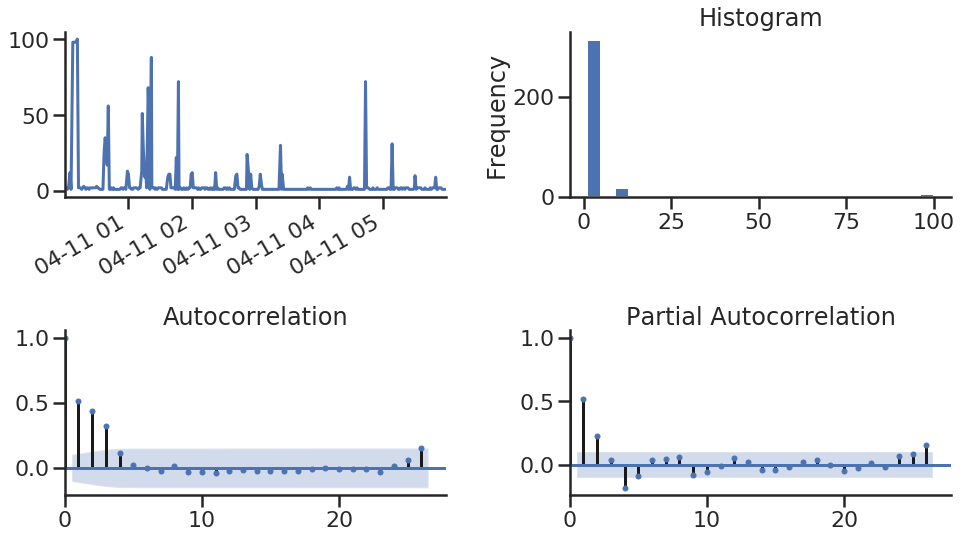

In [65]:
#画ACF和PACF
    
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax 

tsplot(dts)

可以看出ACF呈拖尾状，PACF第2个后截尾，可初步断定序列适合AR(2)模型。  
根据时间序列的识别规则，采用 ACF 图、PAC 图，AIC 准则（赤道信息量准则）和 BIC 准则（贝叶斯准则）相结合的方式来确定 ARMA 模型的阶数, 应当选取 AIC 和 BIC 值达到最小的那一组为理想阶数。
 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARIMA
===================================================================
Model:              ARIMA            BIC:                 2790.6060
Dependent Variable: D.y              Log-Likelihood:      -1383.6  
Date:               2020-05-22 10:16 Scale:               1.0000   
No. Observations:   345              Method:              css-mle  
Df Model:           3                Sample:              1        
Df Residuals:       342                                   6        
Converged:          1.0000           S.D. of innovations: 13.345   
No. Iterations:     7.0000           HQIC:                2781.355 
AIC:                2775.2318                                      
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const        0.0002     0.3849    0.0006   0.9995   -0.7542    0.7547
ma.L1.D.y   -0.4820     0.0534   -9.0299   0.0000   -0.5866   -0.3774
ma.L2.D.y    0.0164     0.0842    0.1948   0.8457   -0.1486    0.1814
----------------------------------------------------------------------------
                Real           Imaginary          Modulus          Frequency
----------------------------------------------------------------------------
MA.1           2.2464             0.0000           2.2464             0.0000
MA.2          27.1422             0.0000          27.1422             0.0000
===================================================================

"""

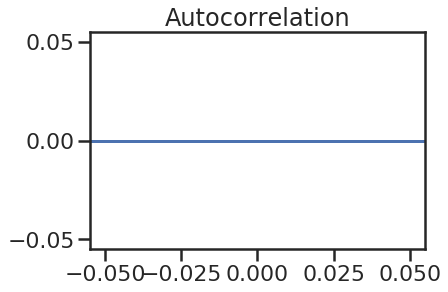

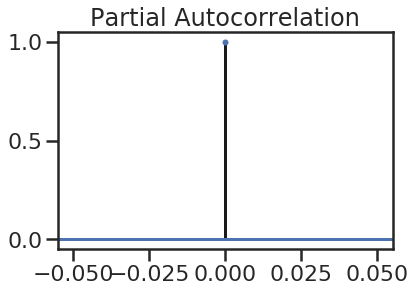

In [116]:

#画出acf和pacf
sm.graphics.tsa.plot_acf(diff_series)
sm.graphics.tsa.plot_pacf(diff_series)
#arima模型
from statsmodels.tsa.arima_model import ARIMA
p,d,q = 0,1,2
model = ARIMA(train,order=(p,d,q))#freq是频率,根据数据填写
model = model.fit()
model.summary2()

In [114]:
#预测数据
##为未来10个点进行预测， 返回预测结果， 标准误差， 和置信区间
pred = model.forecast(10)
pred

(array([1.92845, 1.93132, 1.93154, 1.93176, 1.93199, 1.93221, 1.93244,
        1.93266, 1.93289, 1.93311]),
 array([13.34541, 15.02956, 16.63579, 18.10004, 19.45439, 20.72041,
        21.9134 , 23.04472, 24.12304, 25.15518]),
 array([[-24.22807,  28.08497],
        [-27.52609,  31.38872],
        [-30.67402,  34.5371 ],
        [-33.54367,  37.4072 ],
        [-36.19792,  40.0619 ],
        [-38.67904,  42.54347],
        [-41.01704,  44.88192],
        [-43.23416,  47.09948],
        [-45.3474 ,  49.21317],
        [-47.37013,  51.23635]]))

In [115]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(test) 
rms = sqrt(mean_squared_error(test, pred[0]))
print(rms)

2020-04-11 05:49:27   9.00000
2020-04-11 05:50:26   1.00000
2020-04-11 05:51:25   1.00000
2020-04-11 05:52:27   2.00000
2020-04-11 05:53:28   2.00000
2020-04-11 05:54:28   2.00000
2020-04-11 05:55:28   1.00000
2020-04-11 05:57:28   1.00000
2020-04-11 05:58:28   1.00000
2020-04-11 05:59:28   1.00000
dtype: float64
2.3502361529972418


![image.png](images/ts.png)